In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
train_folder = '/Users/sumanthshankar/Documents/DataSets/Images/FlowersTrain'
test_folder = '/Users/sumanthshankar/Documents/DataSets/Images/FlowersTest'

train_data = datasets.ImageFolder(root = train_folder, transform = train_transform)
test_data = datasets.ImageFolder(root = test_folder, transform = test_transform)

In [4]:
print(len(train_data))
print(len(test_data))
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = True)

6920
1269


In [8]:
for images, labels in test_loader:
    break

In [9]:
images.shape

torch.Size([10, 3, 224, 224])

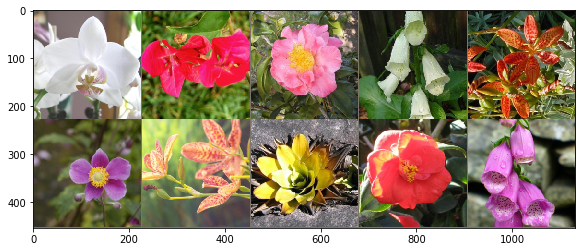

In [10]:
from torchvision.utils import make_grid
im = make_grid(images, nrow=5)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 102)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

In [12]:
torch.manual_seed(101)

model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [13]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=102, bias=True)
)

In [14]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.00000000  accuracy:  99.500%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.00000000  accuracy:  99.750%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.00000000  accuracy:  99.833%

Duration: 393 seconds


[tensor(0., grad_fn=<NllLossBackward>)]


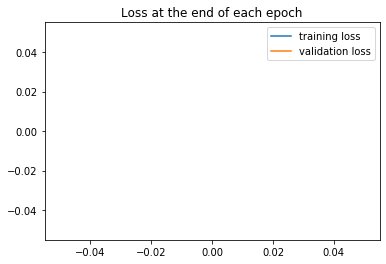

In [17]:
print(train_losses)
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

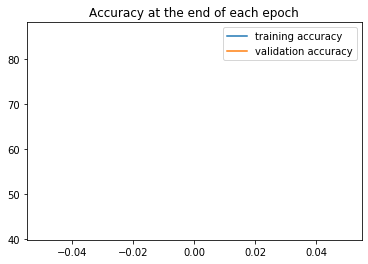

In [16]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [18]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for imgaes, labels in test_loader:
        print(images)
        outputs = model(images)

tensor([[[[-0.3883, -0.3883, -0.3883,  ...,  1.8379,  1.9064,  1.9407],
          [-0.4226, -0.4226, -0.4226,  ...,  1.5982,  1.7352,  1.8208],
          [-0.4739, -0.4739, -0.4739,  ...,  1.2385,  1.4954,  1.6838],
          ...,
          [ 1.2385,  1.2899,  1.1872,  ...,  0.9646,  1.0159,  1.2214],
          [ 1.2728,  1.1872,  0.8789,  ...,  0.9474,  0.9988,  1.1700],
          [ 1.1872,  0.8618,  0.4508,  ...,  0.9132,  0.9988,  1.1700]],

         [[-0.2325, -0.2325, -0.2325,  ...,  2.3936,  2.3936,  2.4286],
          [-0.2675, -0.2675, -0.2675,  ...,  2.3410,  2.3761,  2.4286],
          [-0.3200, -0.3200, -0.3200,  ...,  2.1485,  2.2360,  2.3761],
          ...,
          [ 1.6057,  1.5882,  1.3782,  ...,  1.0455,  1.1856,  1.4132],
          [ 1.5532,  1.3957,  1.0105,  ...,  1.0280,  1.1681,  1.3606],
          [ 1.3081,  0.9580,  0.4853,  ...,  0.9755,  1.1681,  1.3606]],

         [[-0.2358, -0.2358, -0.2184,  ...,  2.1346,  2.3263,  2.3960],
          [-0.2707, -0.2707, -

In [20]:
import scipy.io
mat = scipy.io.loadmat('/Users/sumanthshankar/Documents/DataSets/imagelabels.mat')

In [21]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}